# Capstone Project - Part II
by **Lukas Schumi**

For the chapters 1. _Introduction_ and 2. _Data acquisition_ please see "Capstone Project - Part I"

Importing the necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Importing the csv files which were created in Part I

In [2]:
df_shops = pd.read_csv("shops.csv")
df_loc = pd.read_csv("locations.csv")

In [3]:
df_shops.head()

,Name,Adress,Cat,Lat,Lng
0,Laufsport Blutsch,"['Liniengasse 24', '1060 Wien', 'Österreich']",Sporting Goods Shops,48.192410,16.344130
1,bergfuchs,"['Kaiserstraße 15', 'Österreich']",Sporting Goods Shops,48.198428,16.341169
2,Foot Locker,"['Mariahilfer Str. 104', '1070 Wien', 'Österre...",Sporting Goods Shops,48.196810,16.344213
3,HANGLOOSE Boardsports Store,"['Favoritenstr. 28 (Mayerhofgasse)', '1040 Wie...",Sporting Goods Shops,48.192957,16.370626
4,Blue Tomato Shop Wien,"['Neubaugasse 3', '1070 Wien', 'Österreich']",Board Shops,48.198623,16.349967


In [4]:
df_loc.head()

,Name,Adress,Category,Lat,Lng
0,Ostermann Kickboxen,"['Gärtnergasse 4', '1030 Wien', 'Österreich']",Athletics & Sports,48.206592,16.388362
1,Octagon Kickboxing,['Österreich'],Boxing Gyms,48.196937,16.344497
2,Boxteam Vienna,"['Stadlauerstrasse 41a', '1220 Wien', 'Österre...",Boxing Gyms,48.232381,16.456469
3,Gym 23,"['Anton-Baumgartner-Straße 40', '1230 Wien', '...",Gyms or Fitness Centers,48.152249,16.318870
4,OeAV Edelweiss-Center,"['Walfischg. 12', '1010 Wien', 'Österreich']",Climbing Gyms,48.202806,16.372683


In [5]:
df_shops.shape

(68, 5)

In [6]:
df_loc.shape

(329, 5)

Looking at the statistics to figure out how many venues are in the respective category and if this categories coincide with the categories of goods offered at XXL Sports & Outdoor

In [7]:
df_loc['Category'].describe()

count      329
unique      43
top       Gyms
freq        38
Name: Category, dtype: object

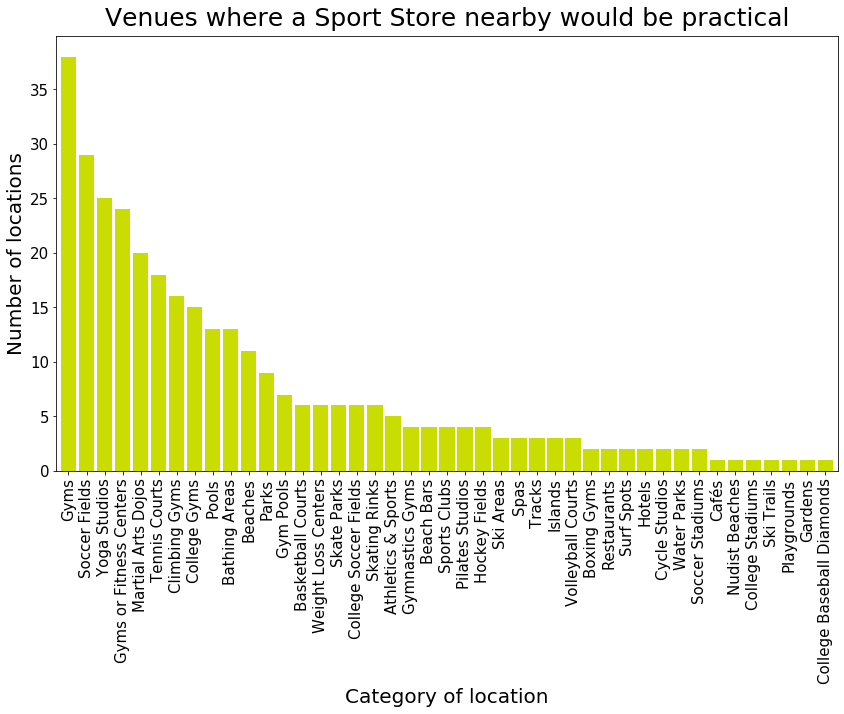

In [8]:
ax = df_loc['Category'].value_counts().plot(kind='bar',
                                            figsize=(14,8),
                                            width=.85,
                                                color = '#c9dd03')
ax.set_title("Venues where a Sport Store nearby would be practical", fontsize=25, y=1.01)
ax.set_xlabel("Category of location", fontsize=20) 
ax.set_ylabel("Number of locations", fontsize=20) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

The first 6 venues in the graph coincide perfectly with the goods XXL specialized in. Therefore these locations might be a good indicator where a sporting goods store like XXL might be practical to have nearby.

In the next step I will figure out what are the main categories of sporting goods stores in Vienna.

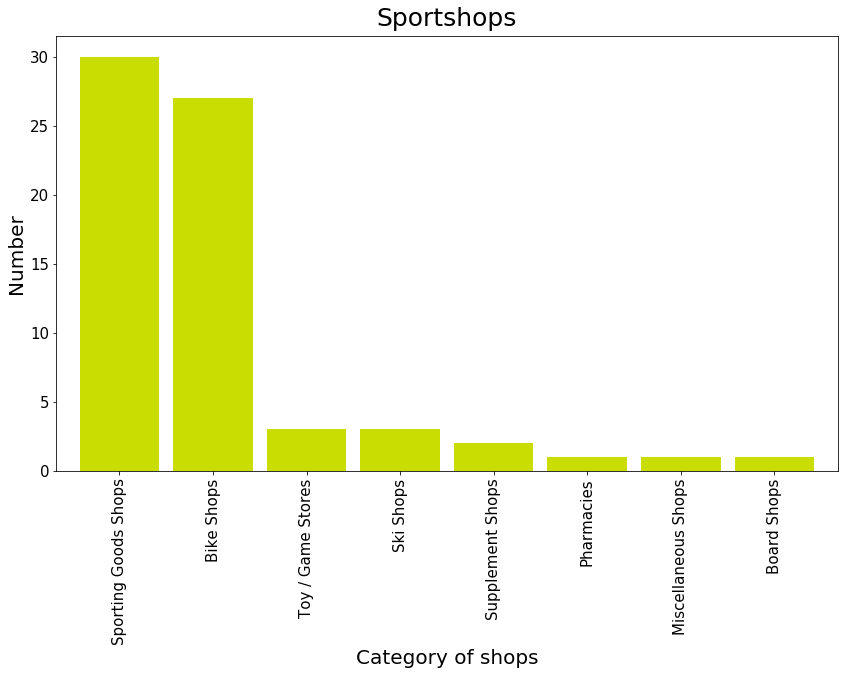

In [9]:
ax = df_shops['Cat'].value_counts().plot(kind='bar',
                                            figsize = (14,8),
                                            width = .85,
                                            color = '#c9dd03')
ax.set_title("Sportshops", fontsize=25, y=1.01)
ax.set_xlabel("Category of shops", fontsize=20) 
ax.set_ylabel("Number", fontsize=20) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

## <font color='#c9dd03'>3. Methodology and Analysis</font>

The goal of this project is to find the perfect location for a new store, where the neighborhood is surrounded by different sport-related venues. Then I will apply  **k-Means Clustering**, a simple unsupervised machine learning algorithm, to make segmentations of venues.
The new location should cover an area which isn't already covered by another XXL store. There should also be no or hardly any competitors in the same cluster.
Finally, when a matching cluster is found, the coordinates of the future store location will be calculated to be the closest point possible to the venues in the cluster.  
Based on the goal of this project, I will describe below, what is needed to perform this search and which data sources will be used:

* number of sport facilities in Vienna
* number of sport shops in Vienna
* segmentation of sport venues in 4 clusters to match the location of 4 stores
* distance of the final location in relation to the other points in the cluster
* checking for traffic connection and public transport

In [10]:
vienna_lat = 48.208489
vienna_long = 16.373156

stores_map = folium.Map(location=[vienna_lat, vienna_long], zoom_start=12)

# add a red circle marker to the St. Stephen's Cathedral
folium.CircleMarker(
    [vienna_lat, vienna_long],
    radius=5,
    color='red',
    popup='Stephansdom',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(stores_map)

# add the sporting goods stores as green circle markers with their category as pop-up label
for lat, lng, label in zip(df_loc.Lat, df_loc.Lng, df_loc.Category):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        popup=label,
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(stores_map)

# display map
stores_map

### <font color='#c9dd03'>3.1 Clustering sport facilities to check present coverage</font>

For the next step we only need the coordinates of the sport facility venues

In [11]:
df_loc_latlng = df_loc.drop(df_loc.iloc[:, 0:3], axis=1)
df_loc_latlng = df_loc_latlng[['Lng', 'Lat']]
df_loc_latlng.head()

,Lng,Lat
0,16.388362,48.206592
1,16.344497,48.196937
2,16.456469,48.232381
3,16.318870,48.152249
4,16.372683,48.202806


In [12]:
X = df_loc_latlng.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-1.48675031e-01],
       [-4.17508703e-01],
       [ 5.69405368e-01],
       [-1.66181845e+00],
       [-2.54083826e-01],
       [ 5.43360938e-01],
       [ 5.08367470e-01],
       [ 7.80994354e-01],
       [-2.46338953e+00],
       [-3.97859165e-01],
       [-8.56361104e-02],
       [-1.53771066e-01],
       [-3.79221040e-02],
       [ 2.70438157e+00],
       [-5.94291358e-01],
       [-9.17301617e-02],
       [-1.40807038e+00],
       [-3.57615567e+00],
       [-8.46112511e-01],
       [-8.58757639e-01],
       [-5.37434189e-01],
       [ 4.45962866e-01],
       [ 7.92372037e-01],
       [ 6.23676094e-02],
       [-9.06459350e-01],
       [ 6.63578661e-01],
       [-2.18726387e-01],
       [-8.29857909e-01],
       [-1.19752834e+00],
       [ 1.49738655e+00],
       [ 6.42933244e-01],
       [-3.12289986e-01],
       [ 7.08442334e-01],
       [ 4.07424055e-02],
       [ 2.21088071e+00],
       [ 2.70515296e-01],
       [-1.92583516e+00],
       [-3.98443136e-02],
       [-1.0

Since there are already three XXL Sports & Outdoor Stores in Vienna I used the k-Means machine learning algorithm to divide the venues in three areas and see how good the three stores cover those.

In [13]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 2 0 1 2 0 0 0 1 2 2 2 2 0 2 2 1 1 2 2 2 2 0 2 2 0 2 2 1 0 0 2 0 2 0 2 1
 2 1 2 1 1 0 0 0 2 2 2 2 2 2 0 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 1 0 2 0 2 0 0
 0 0 0 0 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 0 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 2 2 0 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 1 2 2 2 2 0 0 1 2 2 2 2 1 2 0 2 2 2 2 0 1 1 2 2 2 1 0 1 0
 0 0 2 1 2 0 2 0 2 2 2 0 0 2 2 1 0 0 0 2 0 2 0 1 0 1 1 1 1 2 2 2 2 1 0 1 1
 0 2 1 2 2 2 2 2 0 2 0 0 2 2 1 1 2 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0
 2 2 2 0 0 2 0 2 2 2 2 2 0 0 2 2 0 0 0 0 0 0 2 2 1 0 1 0 2 2 0 2 2 2 0 0 1
 2 0 1 2 2 2 0 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 0 2 2 0 2 0 2 2]


In [14]:
df_loc_latlng["Labels"] = labels
df_loc_latlng.head(5)

,Lng,Lat,Labels
0,16.388362,48.206592,2
1,16.344497,48.196937,2
2,16.456469,48.232381,0
3,16.318870,48.152249,1
4,16.372683,48.202806,2


In [15]:
ZeroFrame = df_loc_latlng[df_loc_latlng['Labels'] == 0]
OneFrame = df_loc_latlng[df_loc_latlng['Labels'] == 1]
TwoFrame = df_loc_latlng[df_loc_latlng['Labels'] == 2]

In [16]:
venues_map = folium.Map(location=[vienna_lat, vienna_long], zoom_start=11) 

folium.CircleMarker(
    [vienna_lat, vienna_long],
    radius=5,
    color='red',
    popup='Stephansdom',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# Label 0
for lat, lng in zip(ZeroFrame.Lat, ZeroFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'blue',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(venues_map)
    
# Label 1
for lat, lng in zip(OneFrame.Lat, OneFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(venues_map)

# Label 2
for lat, lng in zip(TwoFrame.Lat, TwoFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'yellow',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Coordinates of the three XXL Stores

In [17]:
coord_DZ = [48.242362, 16.436018]
coord_GG = [48.199883, 16.353374]
coord_SCS = [48.103979, 16.317382]

coordinates = [coord_DZ, coord_GG, coord_SCS]

In [18]:
xxl_map = folium.Map(location=[vienna_lat, vienna_long], zoom_start=11) 

# Label 0
for lat, lng in zip(ZeroFrame.Lat, ZeroFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'blue',
        popup=label,
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(xxl_map)
    
# Label 1
for lat, lng in zip(OneFrame.Lat, OneFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        popup=label,
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(xxl_map)

# Label 2
for lat, lng in zip(TwoFrame.Lat, TwoFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'yellow',
        popup=label,
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(xxl_map)
    
    
for coord in coordinates:
# add a red circle marker to represent the XXL Stores
    folium.CircleMarker(
        [coord[0], coord[1]],
        radius=10,
        color='red',
        popup='XXL Store',
        fill = True,
        fill_color = 'red',
        fill_opacity = 1
    ).add_to(xxl_map)



# display map
xxl_map

One can see, there three stores perfectly cover the area of venues created by the k-Means algorithm.

### <font color='#c9dd03'>3.2 Clustering sport facilities to check possible future coverage</font>

Since we want to open a fourth store, we now will create 4 clusters with the same algorithm and see if we can find a place for another store.

In [19]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

df_loc_latlng["Labels"] = labels

ZeroFrame = df_loc_latlng[df_loc_latlng['Labels'] == 0]
OneFrame = df_loc_latlng[df_loc_latlng['Labels'] == 1]
TwoFrame = df_loc_latlng[df_loc_latlng['Labels'] == 2]
ThreeFrame = df_loc_latlng[df_loc_latlng['Labels'] == 3]

In [20]:
four_map = folium.Map(location=[vienna_lat, vienna_long], zoom_start=10) 

# Label 0
for lat, lng in zip(ZeroFrame.Lat, ZeroFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'blue',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(four_map)
    
# Label 1
for lat, lng in zip(OneFrame.Lat, OneFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(four_map)

# Label 2
for lat, lng in zip(TwoFrame.Lat, TwoFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'yellow',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(four_map)

    
# Label 3
for lat, lng in zip(ThreeFrame.Lat, ThreeFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'orange',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(four_map)
    
    
for coord in coordinates:
# add a red circle marker to represent the XXL Stores
    folium.CircleMarker(
        [coord[0], coord[1]],
        radius=10,
        color='red',
        popup='XXL Store',
        fill = True,
        fill_color = 'red',
        fill_opacity = 1
    ).add_to(four_map)



# display map
four_map

As one can easily see, the three stores still cover three different areas nicely. A fourth cluster in the north is not yet covered.

To find an area that's not too crowded with competitors let's project those on the map.

In [21]:
shops_map = folium.Map(location=[vienna_lat, vienna_long], zoom_start=12)

# add a red circle marker to the St. Stephen's Cathedral
folium.CircleMarker(
    [vienna_lat, vienna_long],
    radius=5,
    color='red',
    popup='Stephansdom',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(shops_map)

# add black circle markers to represent sport stores
for lat, lng, label in zip(df_shops.Lat, df_shops.Lng, df_shops.Cat):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'black',
        popup=label,
        fill = True,
        fill_color= 'black',
        fill_opacity = 1
    ).add_to(shops_map)

# display map
shops_map

Combining the data to get an overview.

In [22]:
combi_map = folium.Map(location=[vienna_lat, vienna_long], zoom_start=10) 

# Area 1 with blue circle markers
for lat, lng in zip(ZeroFrame.Lat, ZeroFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'blue',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(combi_map)
    
# Area 2 with green circle markers
for lat, lng in zip(OneFrame.Lat, OneFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(combi_map)

# Area 3 with yellow circle markers
for lat, lng in zip(TwoFrame.Lat, TwoFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'yellow',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(combi_map)

    
# Area 4 with orange circle markers
for lat, lng in zip(ThreeFrame.Lat, ThreeFrame.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'orange',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(combi_map)
    
# Sport stores in black    
for lat, lng, label in zip(df_shops.Lat, df_shops.Lng, df_shops.Cat):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'black',
        popup=label,
        fill = True,
        fill_color= 'black',
        fill_opacity = 1
    ).add_to(combi_map)

    
for coord in coordinates:
# big red circle markes for XXL Stores
    folium.CircleMarker(
        [coord[0], coord[1]],
        radius=20,
        color='red',
        popup='Stephansdom',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.4
    ).add_to(combi_map)

# display map
combi_map

Most of the sport facilities as well as the sporting goods shops are in the city center. Another hot spot of sporting venues are along the Danube north-east of the city. Both areas are covered by a XXL Store.  
What one notices immediately when looking at the graphic above is, that there are quite some venues in the neighboring city Klosterneuburg, but, as it seems no sport shops whatsoever.  
In the next section I will take a closer look at the city of Klosterneuburg.


### <font color='#c9dd03'>3.3 Reevaluation: Openeing a store in Klosterneuburg?</font>

In [23]:
Klosterneuburg = [48.30805,16.3238495]

Using the **Foursquare API** to examine a potential location in Klosterneuburg

In [24]:
CLIENT_ID = 'XXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXX' # your Foursquare Secret
VERSION = '20201504'

Using a search radius of 2km.  
A larger radius would on the one hand get too far away from Vienna in the north and on the other hand reach into Vienna in the south.

In [25]:
radius = 2000

In [26]:
shops = ['4bf58dd8d48988d1f2941735', '5bae9231bedf3950379f89d2', '56aa371be4b08b9a8d573566', '5744ccdfe4b0c0459246b4cd', '4bf58dd8d48988d115951735']

In [27]:
categories_shops = []

for x in shops:
    shop_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, Klosterneuburg[0], Klosterneuburg[1], x, radius)
    res = requests.get(shop_url).json()
    categories_shops.append(res)

In [28]:
grouplist = []

for k in range (0, len(categories_shops)):
    
    x = categories_shops[k]['response']['groups']
    grouplist.append(x)

listofall = []

for a in range (0, len(grouplist)):
    b = grouplist[a][0]['items']
    for c in range (0, len(b)):
        if len(b) != 0:
            z = b[c]
            listofall.append(z)

In [29]:
allshops = []

for element in range (0, len(listofall)):
    c = listofall[element]['venue']
    allshops.append(c)

In [30]:
venue_namelist = []
venue_adresslist = []
venue_catlist = []
venue_latlist = []
venue_lnglist = []

for i in range(0, len(allshops)):
    venues_name = allshops[i]['name']
    venues_adress = allshops[i]['location']['formattedAddress']
    venues_category = allshops[i]['categories'][0]['pluralName']
    venues_lat = allshops[i]['location']['lat']
    venues_lng = allshops[i]['location']['lng']
    venue_namelist.append(venues_name)
    venue_adresslist.append(venues_adress)
    venue_catlist.append(venues_category)
    venue_latlist.append(venues_lat)
    venue_lnglist.append(venues_lng)

In [31]:
data = {'Name':venue_namelist, 'Adress': venue_adresslist, 'Cat': venue_catlist, 'Lat': venue_latlist, 'Lng': venue_lnglist }
df_kloster = pd.DataFrame(data)

df_kloster.head()

,Name,Adress,Cat,Lat,Lng
0,SP SPEED PLANET GmbH,"[In der Au 2-4, 3400 Klosterneuburg, Österreich]",Bike Shops,48.309961,16.328545
1,CH Huber Bikes,"[Weidlinger Straße 28, Österreich]",Bike Shops,48.297164,16.333875
2,huberista,[Österreich],Bike Shops,48.295800,16.331135


List of sporting goods shops in the Klosterneuburg area

In [32]:
klosterneuburg_map = folium.Map(location=[Klosterneuburg[0], Klosterneuburg[1]], zoom_start=13)

for lat, lng in zip(df_kloster.Lat, df_kloster.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(klosterneuburg_map)

# display map
klosterneuburg_map

In [33]:
Gym_Fitness = '4bf58dd8d48988d175941735' 

#subcategorys of gyms
Boxing_Gym ='52f2ab2ebcbc57f1066b8b47'
Climbing_Gym = '503289d391d4c4b30a586d6a'
Cycle_Studio = '52f2ab2ebcbc57f1066b8b49'
Gym_Pool = '4bf58dd8d48988d105941735'
Gymnastics_Gym = '52f2ab2ebcbc57f1066b8b48'
Gym = '4bf58dd8d48988d176941735'
Martial_Arts_Dojo = '4bf58dd8d48988d101941735'
Outdoor_Gym = '58daa1558bbb0b01f18ec203'
Pilates_Studio = '5744ccdfe4b0c0459246b4b2'
Track = '4bf58dd8d48988d106941735'
Weight_Loss_Center = '590a0744340a5803fd8508c3'
Yoga_Studio = '4bf58dd8d48988d102941735'

Basketball_Court = '4bf58dd8d48988d1e1941735'  
Hockey_Field = '4f452cd44b9081a197eba860'
Skate_Park = '4bf58dd8d48988d167941735'
Skating_Rink = '4bf58dd8d48988d168941735'
Soccer_Field = '4cce455aebf7b749d5e191f5'
Sports_Club = '52e81612bcbc57f1066b7a2e'
Tennis_Court = '4e39a956bd410d7aed40cbc3'
Volleyball_Court = '4eb1bf013b7b6f98df247e07'
Bathing_Area = '52e81612bcbc57f1066b7a28'
Beach = '4bf58dd8d48988d1e2941735'
Ski_Area = '4bf58dd8d48988d1e9941735'
College_Gym = '4bf58dd8d48988d1b2941735'
College_Stadium = '4bf58dd8d48988d1b4941735'

In [34]:
categorylist = [Boxing_Gym, Climbing_Gym, Cycle_Studio, Gym_Pool, Gymnastics_Gym, Gym, Martial_Arts_Dojo, Outdoor_Gym, Pilates_Studio, Track, Weight_Loss_Center,Yoga_Studio, Basketball_Court, Hockey_Field , Skate_Park , Skating_Rink , Soccer_Field , Sports_Club , Tennis_Court , Volleyball_Court ,Bathing_Area , Beach, Ski_Area , College_Gym ,College_Stadium]

In [35]:
resultlist =[]

for x in categorylist:
    url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, Klosterneuburg[0], Klosterneuburg[1], x, radius)
    res = requests.get(url2).json()
    resultlist.append(res)
    
len(resultlist)

25

In [36]:
venlist = []
for k in range (0, len(resultlist)):
    venues = resultlist[k]['response']['groups'][0]['items']
    venlist.append(venues)

In [37]:
loclist = []
for x in range (0, len(venlist)):
    y = venlist[x]
    for z in range (0, len(y)):
        location = y[z]
        loclist.append(location)

In [38]:
div_list = []
div_dict = []

for i in range (0, len(loclist)):
    if type(loclist[i]) == dict:
        div_dict.append(loclist[i])
    else:
        div_list.append(loclist[i])

In [39]:
namelist = []
adresslist = []
catlist = []
latlist = []
lnglist = []

for z in range (0, len(loclist)):
    location_name = loclist[z]['venue']['name']
    location_adress = loclist[z]['venue']['location']['formattedAddress']
    location_category = loclist[z]['venue']['categories'][0]['pluralName'] 
    location_lat = loclist[z]['venue']['location']['labeledLatLngs'][0]['lat']
    location_lng = loclist[z]['venue']['location']['labeledLatLngs'][0]['lng']
    namelist.append(location_name)
    adresslist.append(location_adress)
    catlist.append(location_category)
    latlist.append(location_lat)
    lnglist.append(location_lng)

In [40]:
locations = {'Name':namelist, 'Adress': adresslist, 'Category': catlist, 'Lat': latlist, 'Lng': lnglist }
df_kloster_location = pd.DataFrame(locations)
df_kloster_location.head(10)

,Name,Adress,Category,Lat,Lng
0,Die Kletterei,"[In der Au 1, 3400 Klosterneuburg, Österreich]",Climbing Gyms,48.309056,16.329997
1,Kunsteisbahn Happyland,"[3400 Klosterneuburg, Klosterneuburg, Österreich]",Skating Rinks,48.309405,16.329848
2,Wiener Ruderclub Pirat Strombootshaus,"[Stromkilometer 1940,9, Langenzersdorf, Österr...",Sports Clubs,48.322676,16.337395
3,1. KTV,[Österreich],Tennis Courts,48.308623,16.330054
4,Donaustrand Weidling,[Österreich],Bathing Areas,48.299832,16.341482
5,Gegenüber Vom Strandbad Klosterneuburg,[Österreich],Bathing Areas,48.301402,16.341618
6,Strandbad Klosterneuburg,"[Linker Strandweg, 3400 Klosterneuburg, Österr...",Beaches,48.307638,16.338006
7,Gegenüber Vom Strandbad Klosterneuburg,[Österreich],Beaches,48.301402,16.341618
8,Alte Militärschwimmschule Klosterneuburg,"[Klosterneuburg, Österreich]",Beaches,48.295043,16.333112
9,Pionierinsel,[Österreich],Beaches,48.297917,16.341512


In [41]:
klosterneuburg_location_map = folium.Map(location=[Klosterneuburg[0], Klosterneuburg[1]], zoom_start=12)

for lat, lng in zip(df_kloster_location.Lat, df_kloster_location.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(klosterneuburg_location_map)

klosterneuburg_location_map

Finding the closest point to all the venues

In [42]:
df_kloster_location.iloc[:,:].mean()

Lat    48.305299
Lng    16.336464
dtype: float64

In [43]:
New_store = [48.305299, 16.336464]

In [44]:
klosterneuburg_location_map = folium.Map(location=[New_store[0], New_store[1]], zoom_start=14)

# add a red circle marker to represent the position of a possible new store
folium.CircleMarker(
    [New_store[0], New_store[1]],
    radius=12,
    color='red',
    popup='Possibly a future XXL Store',
    fill = True,
    fill_color = '#c9dd03',
    fill_opacity = 1
).add_to(klosterneuburg_location_map)


for lat, lng in zip(df_kloster_location.Lat, df_kloster_location.Lng):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color= 'green',
        fill = True,
        fill_color= '#c9dd03',
        fill_opacity=0.6
    ).add_to(klosterneuburg_location_map)

# display map
klosterneuburg_location_map

## <font color='#c9dd03'>4. Results</font>

The so found position satisfies all criteria stated in the first part:
* Sport facilities are nearby
* There is hardly any competition around
* But there are still enough stores which invite to stroll
* The main train station with a park and ride site is just around the corner

## <font color='#c9dd03'>5. Conclusions</font>

In this project I set a goal to find a new location for the next **XXL Sports & Outdoor store in Vienna**, considering mainly two prerequisites.
The two main conditions for the new location were a close proximity to any sport-related venue and an area with shopping possibilities but not to much competition.

On **[developer.foursquare.com](https://developer.foursquare.com/docs/build-with-foursquare/categories/)** I found a register of all existing categories of venues. After compiling a catalog of all the categories which are somehow related to sportive activities, I utilized the **Foursquare API** to generate a list of every venue matching at least one entry in the catalog.

In the next step I repeated that process to find all the stores selling sporting goods, once again ordered by category. This categories were selected and recorded, for they might have been important when a final location had been found, to analyze the competition in the immediate surrounding. As it turned out, this step would not have been necessary since there are no shops focus on sports near the found location.

As vantage point for my search I defined the **[St. Stephen's Cathedral](https://en.wikipedia.org/wiki/St._Stephen%27s_Cathedral,_Vienna "Wikipedia")** ("Stephansdom" in German), one of the most well known landmarks of the city, located in the city center.

Starting from St. Stephen's Cathedral, I drew a radius of 15km and defined that as my search area. I choose that distance for the resulting circle covered the whole city as well as quite a bit of the surrounding areas which is still easy to reach by public transport.

In the first part of the Data Analysis I applied the **k-Means machine learning algorithm** to cluster the previously found sporting venues in 3 areas and checked if the 3 stores already existing in Vienna somehow covered that area. As it turned out every one of those three stores fell exactly into one cluster of venues, which was easily visible on the **Folium map**.

In the next step I used the same algorithm to divide the list of venues into 4 clusters. Once again three of those were still covered by the three existing stores. So for the search of a new location I focused on the fourth cluster.

I superimposed the coordinates of the competitors on the Folium map to see how many other stores were present in the previously mentioned fourth area. As it turned out there were none. Especially not in the neighboring city of **[Klosterneuburg](http://klosterneuburg.at/en)** where there seemed to be quite a high density of sporting facilities.

So I now focused my attention on the city of Klosterneuburg and repeated the first steps for this new vantage point.
The final location was found by calculating the center of mass of the sporting facilities in an area 2km around the city center.
A value of 2km was chosen because a larger radius would on the one hand get too far away from Vienna in the north and on the other hand reach into Vienna in the south.
A final step was to check if any form of public transport and traffic connection was nearby, which luckily was the case in form of the main train station and a park and ride parking garage.

The found information is of course by far not enough to make a final decision about expanding. There are countless of other factors to take into account, like rent prices, available personnel or logistic infrastructure just to name a few. The goal of the above project was not to find a final solution for the problem of expansion, but to give stakeholders a rough idea were they might to look closely for a new branch.